In [1]:
# %pip install scikit-learn
# %pip install pandas 
# %pip install statsmodels
# %pip install xgboost
# %pip install rpy2
# %pip install shap
# %pip install matplotlib
# %pip install keras

In [2]:
from sklearn.ensemble import RandomForestRegressor
from shaprpy.datasets import load_california_housing

import pandas as pd
import xgboost as xgb
from statsmodels.datasets import get_rdataset
from shaprpy import explain
import shap as shap

/nr/samba/user/jbjornstad/shapr-venv/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/nr/samba/user/jbjornstad/opt/R-4.4.2/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib/R/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib/R/lib:", R: "/nr/samba/user/jbjornstad/opt/R-4.4.2/lib:/usr/local/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib/R/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib:/nr/samba/user/jbjornstad/opt/R-4.4.2/lib/R/lib:"
  warnings.warn(
/nr/samba/user/jbjornstad/shapr-venv/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/nr/samba/user/jbjornstad", R: "/nr/samba/user/jbjornstad/shapr/python"
  warnings.warn(
/nr/samba/user/jbjornstad/shapr-venv/lib/python3.10/site-p

In [3]:
def xgboost_model(x_train, y_train, from_file, filename=None): 
    if (from_file): 
        if ( not filename):
            filename = '../xgboost_model'
        model = xgb.Booster()
        model.load_model(filename)
        model.feature_names = x_train.columns.tolist()
    else: 
        model = xgb.XGBRegressor(n_estimators=20, verbosity=0)
        model.fit(x_train, y_train)
    return model

### Verifying against R results

In [4]:
airquality = get_rdataset("airquality", "datasets").data
data = airquality.dropna()

x_var = ["Solar.R", "Wind", "Temp", "Month"]
y_var = "Ozone"

x_train = data[x_var]
y_train = data[y_var]

In [5]:
model = xgboost_model(x_train=x_train, y_train=y_train, from_file=True)

In [6]:
explanation_SAGE = explain(
    model = model,
    x_train = x_train,
    x_explain = x_train,
    approach = 'independence',
    phi0 = y_train.mean().item(),
    seed=1,
    sage = True, 
    response = y_train, 
    verbose = None
)

print(explanation_SAGE["shapley_values_est"])

   explain_id         none    Solar.R        Wind        Temp     Month
1         NaN -1097.314474  146.53804  442.288023  498.620822  3.502053


In [7]:
explanation_SHAP = explain(   
    model = model,
    x_train = x_train,
    x_explain = x_train,
    approach = 'independence',
    phi0 = float(y_train.mean().item()),
    seed= 1,
    verbose = None
)

print(type(explanation_SHAP["shapley_values_est"]))

<class 'pandas.core.frame.DataFrame'>


### Test plotting

In [8]:
from shaprpy.plot import plot

In [9]:
from shap import plots, Explanation

In [10]:
shap_values_df = explanation_SHAP['shapley_values_est'].iloc[[1]]
feature_names = shap_values_df.columns.drop(['explain_id', 'none'])

shap_vals = shap_values_df[feature_names].values
base_values = shap_values_df["none"].values
data = shap_values_df[feature_names].values

explanation = Explanation(
    values=shap_vals,
    base_values=base_values,
    data=data,
    feature_names=feature_names.tolist()
)

In [11]:
explainer = shap.Explainer(model)
shap_values = explainer(x_train)

In [12]:
print(explanation_SHAP["shapley_values_est"])

     explain_id       none   Solar.R       Wind       Temp     Month
1             1  42.099098  3.030332   4.310215 -12.861986  3.110408
2             2  42.099098 -3.358880   3.691014 -11.697075  2.388401
3             3  42.099099 -2.793629  -9.692032 -18.139897  1.190093
4             4  42.099099 -0.513363  -9.576654 -14.383259  0.620829
5             5  42.099101 -1.579514  -2.804843 -15.939206  1.133936
..          ...        ...       ...        ...        ...       ...
107         107  42.099097 -7.574907  -9.163595 -11.039575 -0.891674
108         108  42.099099  1.318196   2.753162 -14.009171 -2.367950
109         109  42.099099 -0.217088 -10.508347 -15.175035 -1.497503
110         110  42.099100 -2.635532   1.077513 -18.545079 -2.513320
111         111  42.099100  4.344556 -11.707045 -13.445780 -1.158783

[111 rows x 6 columns]


In [13]:
print(explanation_SHAP["internal"]["output"]["shap_values_est"])

     explain_id       none   Solar.R       Wind       Temp     Month
1             1  42.099098  3.030332   4.310215 -12.861986  3.110408
2             2  42.099098 -3.358880   3.691014 -11.697075  2.388401
3             3  42.099099 -2.793629  -9.692032 -18.139897  1.190093
4             4  42.099099 -0.513363  -9.576654 -14.383259  0.620829
5             5  42.099101 -1.579514  -2.804843 -15.939206  1.133936
..          ...        ...       ...        ...        ...       ...
107         107  42.099097 -7.574907  -9.163595 -11.039575 -0.891674
108         108  42.099099  1.318196   2.753162 -14.009171 -2.367950
109         109  42.099099 -0.217088 -10.508347 -15.175035 -1.497503
110         110  42.099100 -2.635532   1.077513 -18.545079 -2.513320
111         111  42.099100  4.344556 -11.707045 -13.445780 -1.158783

[111 rows x 6 columns]


In [14]:
print(explanation_SAGE["internal"]["output"]["shap_values_est"])

          none   Solar.R       Wind       Temp     Month
1    42.099098  3.030332   4.310215 -12.861986  3.110408
2    42.099098 -3.358880   3.691014 -11.697075  2.388401
3    42.099099 -2.793629  -9.692032 -18.139897  1.190093
4    42.099099 -0.513363  -9.576654 -14.383259  0.620829
5    42.099101 -1.579514  -2.804843 -15.939206  1.133936
..         ...       ...        ...        ...       ...
107  42.099097 -7.574907  -9.163595 -11.039575 -0.891674
108  42.099099  1.318196   2.753162 -14.009171 -2.367950
109  42.099099 -0.217088 -10.508347 -15.175035 -1.497503
110  42.099100 -2.635532   1.077513 -18.545079 -2.513320
111  42.099100  4.344556 -11.707045 -13.445780 -1.158783

[111 rows x 5 columns]


In [15]:
print(shap_values.data)

[[190.    7.4  67.    5. ]
 [118.    8.   72.    5. ]
 [149.   12.6  74.    5. ]
 [313.   11.5  62.    5. ]
 [299.    8.6  65.    5. ]
 [ 99.   13.8  59.    5. ]
 [ 19.   20.1  61.    5. ]
 [256.    9.7  69.    5. ]
 [290.    9.2  66.    5. ]
 [274.   10.9  68.    5. ]
 [ 65.   13.2  58.    5. ]
 [334.   11.5  64.    5. ]
 [307.   12.   66.    5. ]
 [ 78.   18.4  57.    5. ]
 [322.   11.5  68.    5. ]
 [ 44.    9.7  62.    5. ]
 [  8.    9.7  59.    5. ]
 [320.   16.6  73.    5. ]
 [ 25.    9.7  61.    5. ]
 [ 92.   12.   61.    5. ]
 [ 13.   12.   67.    5. ]
 [252.   14.9  81.    5. ]
 [223.    5.7  79.    5. ]
 [279.    7.4  76.    5. ]
 [127.    9.7  82.    6. ]
 [291.   13.8  90.    6. ]
 [323.   11.5  87.    6. ]
 [148.    8.   82.    6. ]
 [191.   14.9  77.    6. ]
 [284.   20.7  72.    6. ]
 [ 37.    9.2  65.    6. ]
 [120.   11.5  73.    6. ]
 [137.   10.3  76.    6. ]
 [269.    4.1  84.    7. ]
 [248.    9.2  85.    7. ]
 [236.    9.2  81.    7. ]
 [175.    4.6  83.    7. ]
 

5


ValueError: The ax parameter is not supported when plotting multiple features

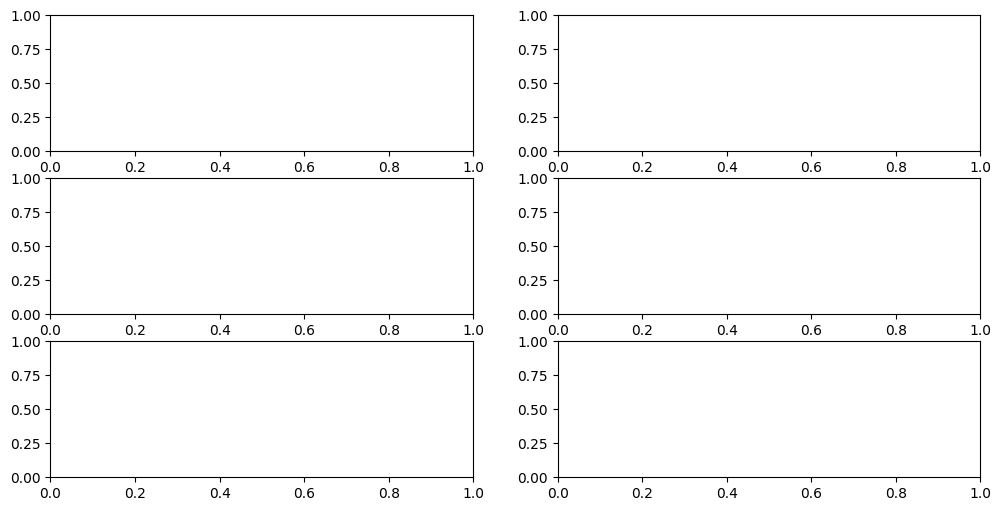

In [ ]:
plot(explanation_SAGE, plot_type="scatter", idx=slice(5,10), indirect_values=True)